In [1]:
!pwd

/home/roman/CODE/tachikoma-analysis/DATA2


In [1]:
# exclude the BNCIShin2017A.pt dataset (need to figure out what's wrong with it (see below))

In [10]:
import torch, os, copy
from einops import rearrange, repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fnames = [i for i in os.listdir() if (i.endswith('.pt') and not i.startswith('BIG'))]
fnames

['BNCI004-2014.pt',
 'BNCIOfner2017.pt',
 'BNCISchirrmeister2017.pt',
 'BNCI004-2015.pt',
 'BNCICho2017.pt',
 'BNCI001-2014.pt',
 'BNCIPhysionetMotorImagery.pt',
 'BNCI001-2015.pt',
 'BNCIGrosse-Wentrup2009.pt',
 'BNCIWeibo2014.pt',
 'BNCIZhou2016.pt',
 'BNCIAlexandreMotorImagery.pt',
 'BNCIShin2017A.pt']

In [4]:
def normalize(_data, axis=0):
    data = _data.clone()
    std = data[:, 0, :].std(axis=0)
    data /= std[0]
    return data

torch.Size([3360, 7, 120]) BNCIOfner2017.pt
torch.Size([13484, 7, 120]) BNCISchirrmeister2017.pt
torch.Size([1420, 7, 120]) BNCI004-2015.pt
torch.Size([9880, 7, 120]) BNCICho2017.pt
torch.Size([2592, 7, 120]) BNCI001-2014.pt
torch.Size([4918, 7, 120]) BNCIPhysionetMotorImagery.pt
torch.Size([5600, 7, 120]) BNCI001-2015.pt
torch.Size([3000, 7, 120]) BNCIGrosse-Wentrup2009.pt
torch.Size([5540, 7, 120]) BNCIWeibo2014.pt
torch.Size([1199, 7, 120]) BNCIZhou2016.pt
torch.Size([480, 7, 120]) BNCIAlexandreMotorImagery.pt
torch.Size([1740, 7, 120]) BNCIShin2017A.pt
torch.Size([53213, 7, 120])


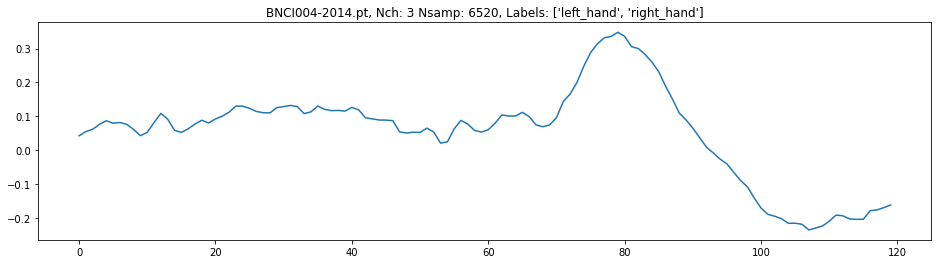

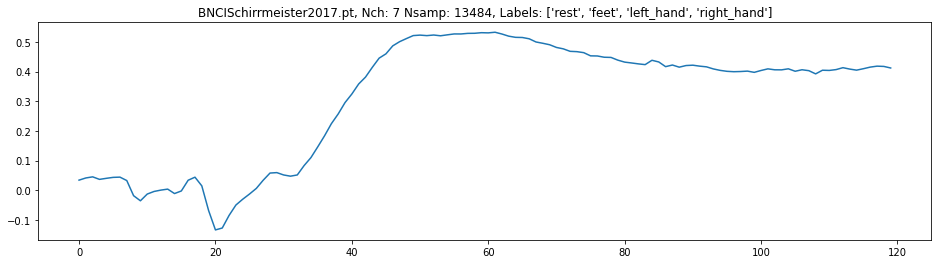

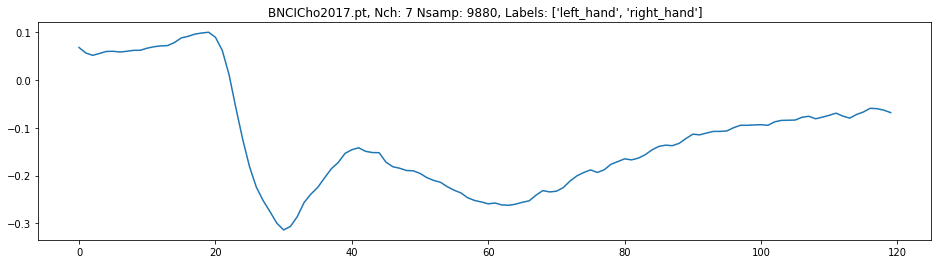

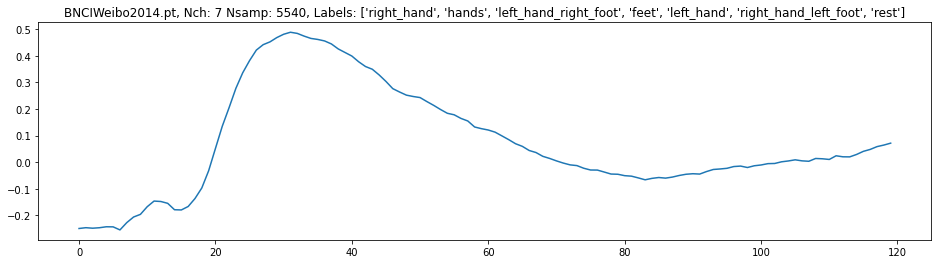

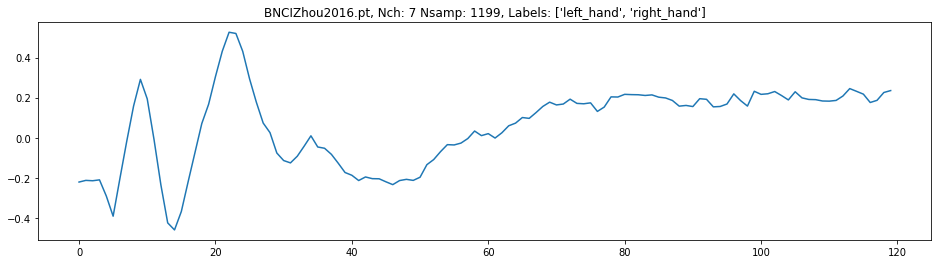

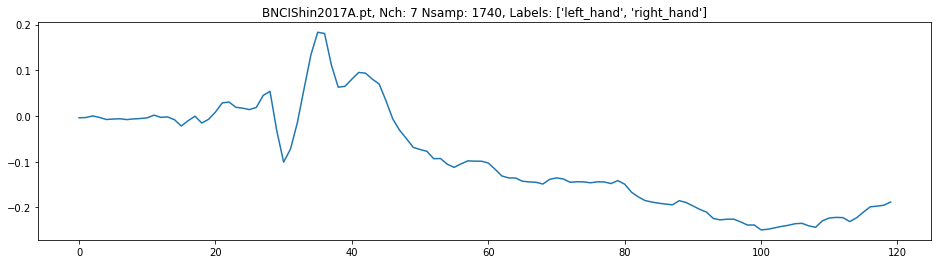

In [5]:
max_t = 120 # 2 s, given that srate is 60 Hz
S, M = [], []

for fn in fnames:
    r = torch.load(fn)
    fix, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax.set_title(f"{fn}, Nch: {r['samples'].shape[1]} Nsamp: {r['samples'].shape[0]}, Labels: {r['meta'].label.unique().tolist()}")
    s = normalize(r['samples'][:, :, :max_t], axis=0)
    ax.plot(s.mean(axis=0)[0,:])
    m = r['meta'].copy()
    m['ds'] = fn
    m = copy.deepcopy(m.to_dict(orient='records'))
    if s.shape[1] == 7:
#         if fn == 'BNCIShin2017A.pt':
#             print(f'excluding {fn}')
#             continue
        S.append(s)
        M += m
        print(s.shape, fn)

        
samples = torch.vstack(S)
meta = pd.DataFrame(M)
info = f"Srate = 100 Hz, passband: 0-45 Hz, channels {r['ChOI']}. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

print(samples.shape)

In [6]:
meta

subject      session    run             label                ds
0            1  imagination  run_0   right_pronation  BNCIOfner2017.pt
1            1  imagination  run_0  right_hand_close  BNCIOfner2017.pt
2            1  imagination  run_0   right_hand_open  BNCIOfner2017.pt
3            1  imagination  run_0  right_supination  BNCIOfner2017.pt
4            1  imagination  run_0   right_hand_open  BNCIOfner2017.pt
...        ...          ...    ...               ...               ...
53208       29    session_4  run_0         left_hand  BNCIShin2017A.pt
53209       29    session_4  run_0        right_hand  BNCIShin2017A.pt
53210       29    session_4  run_0         left_hand  BNCIShin2017A.pt
53211       29    session_4  run_0        right_hand  BNCIShin2017A.pt
53212       29    session_4  run_0         left_hand  BNCIShin2017A.pt

[53213 rows x 5 columns]

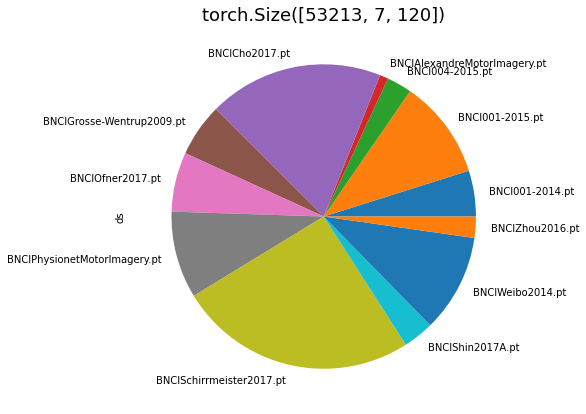

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
meta.groupby('ds').ds.count().plot.pie(ax=ax)
_ = ax.set_title(samples.shape, fontsize=18)

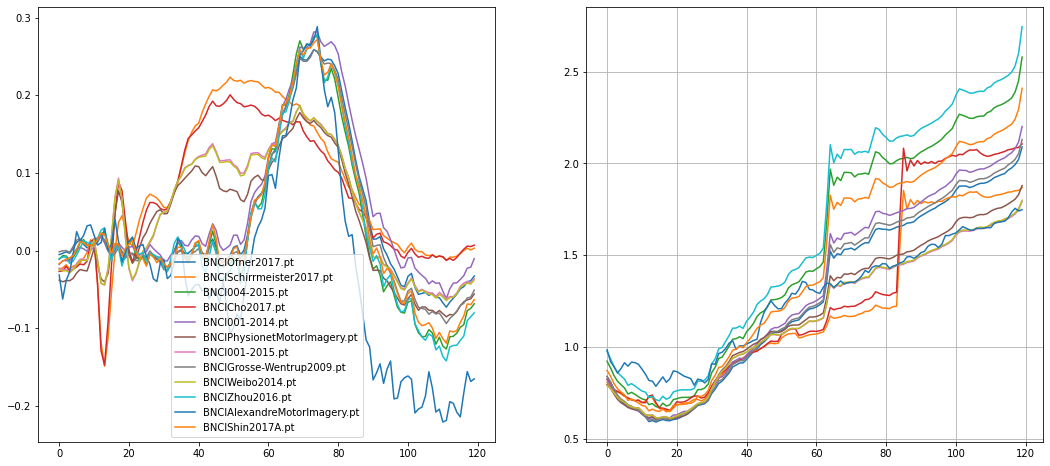

In [11]:
fig, (ax, axt) = plt.subplots(1, 2, figsize=(18, 8))

for ds_name in meta.ds.unique():
    idx = np.where(meta[meta.ds == ds_name])[0]
    rs = rearrange(samples[idx,:,:], 'b c t -> (b c) t')
    ax.plot(rs.mean(axis=0).detach().numpy(), label=ds_name)
    axt.plot(rs.std(axis=0).detach().numpy(), label=ds_name)
ax.legend()
axt.grid()

In [12]:
R = []
for ds_name in meta.ds.unique():
    classes = meta[meta.ds == ds_name].label.unique().tolist()
    R.append({'ds': ds_name, 'lalels': classes, 'Nclass': len(classes)})
pd.DataFrame(R)

ds  \
0               BNCIOfner2017.pt   
1       BNCISchirrmeister2017.pt   
2                BNCI004-2015.pt   
3                 BNCICho2017.pt   
4                BNCI001-2014.pt   
5   BNCIPhysionetMotorImagery.pt   
6                BNCI001-2015.pt   
7      BNCIGrosse-Wentrup2009.pt   
8               BNCIWeibo2014.pt   
9                BNCIZhou2016.pt   
10  BNCIAlexandreMotorImagery.pt   
11              BNCIShin2017A.pt   

                                               lalels  Nclass  
0   [right_pronation, right_hand_close, right_hand...       4  
1                 [rest, feet, left_hand, right_hand]       4  
2                                  [right_hand, feet]       2  
3                             [left_hand, right_hand]       2  
4                             [right_hand, left_hand]       2  
5                             [right_hand, left_hand]       2  
6                                  [feet, right_hand]       2  
7                             [right_hand, left_hand]       2  
8   [right_hand, hands, left_hand_right_foot, feet...       7  
9                             [left_hand, right_hand]       2  
10                           [right_hand, feet, rest]       3  
11                            [left_hand, right_hand]       2

In [18]:
label_map = {l:i for i,l in enumerate(meta.label.unique())}
label_map

{'right_pronation': 0,
 'right_hand_close': 1,
 'right_hand_open': 2,
 'right_supination': 3,
 'rest': 4,
 'feet': 5,
 'left_hand': 6,
 'right_hand': 7,
 'hands': 8,
 'left_hand_right_foot': 9,
 'right_hand_left_foot': 10}

In [20]:
meta['class_id'] = meta.label.map(label_map)

In [21]:
meta

subject      session    run             label                ds  \
0            1  imagination  run_0   right_pronation  BNCIOfner2017.pt   
1            1  imagination  run_0  right_hand_close  BNCIOfner2017.pt   
2            1  imagination  run_0   right_hand_open  BNCIOfner2017.pt   
3            1  imagination  run_0  right_supination  BNCIOfner2017.pt   
4            1  imagination  run_0   right_hand_open  BNCIOfner2017.pt   
...        ...          ...    ...               ...               ...   
53208       29    session_4  run_0         left_hand  BNCIShin2017A.pt   
53209       29    session_4  run_0        right_hand  BNCIShin2017A.pt   
53210       29    session_4  run_0         left_hand  BNCIShin2017A.pt   
53211       29    session_4  run_0        right_hand  BNCIShin2017A.pt   
53212       29    session_4  run_0         left_hand  BNCIShin2017A.pt   

       class_id  
0             0  
1             1  
2             2  
3             3  
4             2  
...         ...  
53208         6  
53209         7  
53210         6  
53211         7  
53212         6  

[53213 rows x 6 columns]

In [27]:
len(meta.ds.unique())

12

In [29]:
torch.save({
    'samples': samples,
    'labels': torch.tensor(meta.class_id.tolist(), dtype=torch.long),
    'meta': meta,
    'info': info},
        'BIG_MI_12_datasets_53213samp.pt')

In [32]:
meta[meta.ds == 'BNCIPhysionetMotorImagery.pt'].class_id.unique()

array([7, 6])

In [ ]:
from sklearn.metrics import cohen_kappa_score as kappa

y1 = [0, 1, 0, 1, 0, 1]
y2 = [0, 1, 1, 0, 0, 1]
kappa(y1, y2)